Imports

In [1]:
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
from datetime import date, timedelta
import math

#for ML

import numpy as np
import datetime

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

from scipy.optimize import curve_fit

from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

Import files

In [2]:
#funzioni

def test(Sensors, df):
    Test = {}
    maxim = len(Sensors.columns)
    for i,col in enumerate(Sensors.columns):
        materials = []
        if i == maxim-1:
            for j,material in enumerate(Sensors[col]):
                f = materials.count(material)+1            
                materials.append(material)
                if list(Test.keys()).count(material + str(f)) == 1:
                    Test[material + str(f)] = pd.concat([Test[material + str(f)],
                                                        df[col:][["R"+str(j+1),
                                                                    "T"+str(j+1),
                                                                    "V"+str(j+1)]].rename(columns = {
                                                            "R"+str(j+1):"R",
                                                            "T"+str(j+1):"HT",
                                                            "V"+str(j+1):"V"
                                                        })])
                else:
                    Test[material + str(f)] = df[col:][["R"+str(j+1),
                                                                    "T"+str(j+1),
                                                                    "V"+str(j+1)]].rename(columns = {
                                                            "R"+str(j+1):"R",
                                                            "T"+str(j+1):"HT",
                                                            "V"+str(j+1):"V"
                                                        })    
        else:
            for j,material in enumerate(Sensors[col]):
                f = materials.count(material)+1            
                materials.append(material)
                if list(Test.keys()).count(material + str(f)) == 1:
                    Test[material + str(f)] = pd.concat([Test[material + str(f)],
                                                        df[col:Sensors.columns[i+1]][["R"+str(j+1),
                                                                    "T"+str(j+1),
                                                                    "V"+str(j+1)]].rename(columns = {
                                                            "R"+str(j+1):"R",
                                                            "T"+str(j+1):"HT",
                                                            "V"+str(j+1):"V"
                                                        })
                                                        ])
                else:
                    Test[material + str(f)] = df[col:Sensors.columns[i+1]][["R"+str(j+1),
                                                                    "T"+str(j+1),
                                                                    "V"+str(j+1)]].rename(columns = {
                                                            "R"+str(j+1):"R",
                                                            "T"+str(j+1):"HT",
                                                            "V"+str(j+1):"V"
                                                        })
    return Test



def tempo(df):
    timezone_offset = datetime.timedelta(hours=2)
    timezone = datetime.timezone(timezone_offset)
    df.ts = df.ts.apply(lambda x: x.replace(tzinfo=timezone))
    return df.ts

def changement(df, sens):
    change = {}
    for i in range(1,9):
        change["S" +str(i)+"_R1"] = "T" + str(i)
        change["S" +str(i)+"_R2"] = "R" + str(i)
        change["S"+ str(i)+"_Voltage"] = "V"+str(i)
    df = df.rename(columns=change)
    tests = test(sens, df)
    df = df.apply(pd.to_numeric, errors='coerce')
    df = df.dropna()
    return df, tests


#import files
    #StChiara
Sensors = read_csv("C:/Users/ricca/OneDrive/challenge3/OneDrive_1_30-6-2023/appa1_timeline.csv",sep = ",")
dfSC = read_csv("C:/Users/ricca/OneDrive/challenge3/WebValley2023-20230628T073810Z-001/WebValley2023/DataSet_FBK/StChiara.csv",sep = ",",parse_dates = ["ts"])
dfAPPA = read_csv("C:/Users/ricca/OneDrive/challenge3/DataSet_APPA-20230628T154631Z-001/DataSet_APPA/APPA1.csv", parse_dates=["Time"])

    #Via Bolzano
Sensors2 = read_csv("C:/Users/ricca/OneDrive/challenge3/OneDrive_1_30-6-2023/appa2_timeline.csv",sep = ",")
df_ViaBolz = read_csv("C:/Users/ricca/OneDrive/challenge3/WebValley2023-20230628T073810Z-001/WebValley2023/DataSet_FBK/ViaBolz.csv",sep = ",",parse_dates = ["ts"])
dfAPPA2 = read_csv("C:/Users/ricca/OneDrive/challenge3/DataSet_APPA-20230628T154631Z-001/DataSet_APPA/APPA2.csv", parse_dates=["Time"])

#file analysis
    #StChiara

Sensors.set_index("channel", inplace = True)
Sensors = Sensors.applymap(lambda x: x.replace("*", ""))

dfSC.set_index("ts", inplace = True)
dfSC, test_Bea_StChiara = changement(dfSC, Sensors)

dfAPPA = dfAPPA.rename(columns={"Time": "ts"})
dfAPPA.ts = tempo(dfAPPA)
dfAPPA.rename(columns = {"Time":"ts"}, inplace= True)

    #Via Bolzano

Sensors2.set_index("channel", inplace = True)
Sensors2 = Sensors2.applymap(lambda x: x.replace("*", ""))

df_ViaBolz.set_index("ts", inplace = True)
df_ViaBolz, test_ViaBolz=changement(df_ViaBolz, Sensors2)

dfAPPA2 = dfAPPA2.rename(columns={"Time": "ts"})
dfAPPA2.ts = tempo(dfAPPA2)
dfAPPA2.rename(columns = {"Time":"ts"}, inplace= True)

ViaBolz, dati

In [3]:
start_date=date(2021,1,1)
end_date=date(2023,6,15)
date_tot=[]
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

def funzione_df_primario(start_date, end_date, df):
    date_vere=[]
    date_tot=[]
    df_slice=[]
    for single_date in daterange(start_date, end_date):
        try:
            df_slice = df[single_date.strftime("%Y-%m-%d"):]
            date_vere.append(single_date)
        except:
            date_tot.append(single_date)
    return df_slice, date_vere, date_tot


def funzione_df_secondario(start_date, end_date, df):
    date_tot1=[]
    df_slice=[]
    for single_date in daterange(start_date, end_date):
        try:
            df_slice = df[single_date.strftime("%Y-%m-%d"):]      
        except:
            date_tot1.append(single_date)
    return df_slice, date_tot1 


def unione(start_date, end_date, date_vere, date_tot, df_intero, df_base):
    date_aggiunte=[]
    for single_date in daterange(start_date, end_date):
        if single_date not in date_vere:
            if single_date not in date_tot:
                date_vere.append(single_date)
                date_aggiunte.append(single_date)
                df_intero=pd.concat([df_intero,df_base.loc[str(single_date)]])


# df1-2
date_vere_group1=[]
date_tot_group1=[]
date_aggiunte_group1=[]
date_tot1_group1=[]
df_slice1=[]
df_slice2=[]

df1 = test_ViaBolz["LaFeO31"]
df1=df1.dropna(how="all")
df1 = df1.loc[df1.R < 0.18e8]
fig = plt.figure(figsize=(15,5))

df2 = test_ViaBolz["LaFeO32"]
df2=df2.dropna(how="all")
df2 = df2.loc[df2.R < 0.7e8]
fig = plt.figure(figsize=(15,5))

df_slice1, date_vere_group1, date_tot_group1 = funzione_df_primario(start_date, end_date, df1)
df_slice2, date_tot1_group1= funzione_df_secondario(start_date, end_date, df2)


unione(start_date, end_date, date_vere_group1, date_tot1_group1, df1, df2)
# date_vere_group1.sort
df1 = df1.sort_index()
print(df1)



# df3-4
date_vere_group2=[]
date_tot_group2=[]
date_aggiunte_group2=[]
date_tot1_group2=[]
df_slice3=[]
df_slice4=[]

df3 = test_ViaBolz["WO31"]
df3=df3.dropna(how="all")
df3 = df3.loc[df3.R < 0.18e8]
fig = plt.figure(figsize=(15,5))

df4 = test_ViaBolz["WO32"]
df4=df4.dropna(how="all")
df4 = df4.loc[df4.R < 3.7e8]
fig = plt.figure(figsize=(15,5))

df_slice3, date_tot1_group2=funzione_df_secondario(start_date, end_date, df3)
df_slice4, date_vere_group2, date_tot_group2=funzione_df_primario(start_date, end_date, df4)

unione(start_date, end_date, date_vere_group2, date_tot1_group2, df4, df3)
# date_vere_group2.sort
df4 = df4.sort_index()
print(df4)



# df5-6
date_vere_group3=[]
date_tot_group3=[]
date_aggiunte_group3=[]
date_tot1_group3=[]
df_slice5=[]
df_slice6=[]

df5 = test_ViaBolz["ZnO1"]
df5=df5.dropna(how="all")
df5 = df5.loc[df5.R < 3.7e8]
fig = plt.figure(figsize=(15,5))

df6 = test_ViaBolz["ZnO2"]
df6=df6.dropna(how="all")
df6 = df6.loc[df6.R < 3.7e8]
fig = plt.figure(figsize=(15,5))

df_slice5, date_vere_group3, date_tot_group3=funzione_df_primario(start_date, end_date, df5)
df_slice6, date_tot1_group3=funzione_df_secondario(start_date, end_date, df6)

unione(start_date, end_date, date_vere_group3, date_tot1_group3, df5, df6)
# date_vere_group3.sort
df5 = df5.sort_index()
print(df5)


# df7-8
# DF3
date_vere_group4=[]
date_tot_group4=[]
date_aggiunte_group4=[]
date_tot1_group4=[]
df_slice7=[]
df_slice8=[]


df7 = test_ViaBolz["STN1"]
df7=df7.dropna(how="all")
df7 = df7.loc[df7.R < 2.8e8]
fig = plt.figure(figsize=(15,5))

df8 = test_ViaBolz["STN2"]
df8=df8.dropna(how="all")
df8 = df8.loc[df8.R < 2.8e8]
fig = plt.figure(figsize=(15,5))

df_slice7, date_tot1_group4=funzione_df_secondario(start_date, end_date, df7)
df_slice8, date_vere_group4, date_tot_group4=funzione_df_primario(start_date, end_date, df8)

unione(start_date, end_date, date_vere_group4, date_tot1_group4, df8, df7)
# date_vere_group4.sort
df8 = df8.sort_index()
print(df8)


#df 9-10
date_tot_group5=[]
date_tot1_group5=[]
date_aggiunte_group5=[]
date_vere_group5=[]
df_slice9=[]
df_slice10=[]

df9 = test_ViaBolz["ZnOg1"]
df9=df9.dropna(how="all")
df9 = df9 .loc[df9.R < 2.8e8]
fig = plt.figure(figsize=(15,5))

df10 = test_ViaBolz["ZnOg2"]
df10=df10.dropna(how="all")
df10 = df10.loc[df10.HT < 165]
fig = plt.figure(figsize=(15,5))

df_slice9, date_tot1_group5=funzione_df_secondario(start_date, end_date, df9)
df_slice10, date_vere_group5, date_tot_group5=funzione_df_primario(start_date, end_date, df10)

unione(date(2021,5,4), date(2021,10,4), date_vere_group5, date_tot1_group5, df10, df9)
date_vere_group5.sort
df10 = df10.sort_index()
print(df10)

# df11
date_tot_group6=[]
df_slice11=[]
date_vere_group6=[]

df11 = test_ViaBolz["ZnOR1"]
df11=df11.dropna(how="all")
df11 = df11.loc[df11.HT < 300]
fig = plt.figure(figsize=(15,5))

df_slice11, date_vere_group6, date_tot_group6=funzione_df_primario(start_date, end_date, df11)
print(df11)


# df12
date_tot_group7=[]
df_slice12=[]
date_vere_group7=[]

df12 = test_ViaBolz["CNT1"]
df12=df12.dropna(how="all")
df12 = df12.loc[df12.HT < 1000]
fig = plt.figure(figsize=(15,5))

df_slice12, date_vere_group7, date_tot_group7=funzione_df_primario(start_date, end_date, df12)
print(df12)
# df13-14
date_tot_group8=[]
date_tot1_group8=[]
date_aggiunte_group8=[]
date_vere_group8=[]
df_slice13=[]
df_slice14=[]

df13 = test_ViaBolz["SmFeO31"]
df13=df13.dropna(how="all")
df13 = df13.loc[df13.HT > 95]
fig = plt.figure(figsize=(15,5))

df14 = test_ViaBolz["SmFeO32"]
df14=df14.dropna(how="all")
df14 = df14.loc[df14.HT > 95]
fig = plt.figure(figsize=(15,5))

df_slice13, date_tot1_group8=funzione_df_secondario(start_date, end_date, df13)
df_slice14, date_vere_group8, date_tot_group8=funzione_df_primario(start_date, end_date, df14)

unione(start_date, end_date, date_vere_group8, date_tot1_group8, df14, df13)
df14 = df14.sort_index()
print(df14)

                                   R     HT     V
ts                                               
2021-01-13 10:31:00+00:00   327680.0   89.6  3.24
2021-01-13 10:32:00+00:00   318136.0   90.0  3.24
2021-01-13 10:34:00+00:00   310597.0   90.1  3.23
2021-01-13 10:35:00+00:00   297215.0   90.5  3.24
2021-01-13 10:36:00+00:00   291920.0   90.6  3.24
...                              ...    ...   ...
2023-06-26 09:07:00+00:00  1702234.0  112.2  3.36
2023-06-26 09:08:00+00:00  1702234.0  112.1  3.36
2023-06-26 09:09:00+00:00  1680410.0  112.2  3.36
2023-06-26 09:10:00+00:00  1680410.0  112.1  3.36
2023-06-26 09:12:00+00:00  1702234.0  112.3  3.36

[1176936 rows x 3 columns]
                                     R     HT     V
ts                                                 
2021-01-13 10:13:00+00:00  104857600.0   53.2  0.36
2021-01-13 10:14:00+00:00  104857600.0   52.6  0.35
2021-01-13 10:15:00+00:00  108323960.0   52.6  0.35
2021-01-13 10:16:00+00:00  112027344.0   52.6  0.35
2021-01-13

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

Santa Chiara, dati

In [4]:
start_date=date(2021,1,1)
end_date=date(2023,6,15)
date_tot=[]
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

def funzione_df_primario(start_date, end_date, df):
    date_vere=[]
    date_tot=[]
    df_slice=[]
    for single_date in daterange(start_date, end_date):
        try:
            df_slice = df[single_date.strftime("%Y-%m-%d"):]
            date_vere.append(single_date)
        except:
            date_tot.append(single_date)
    return df_slice, date_vere, date_tot


def funzione_df_secondario(start_date, end_date, df):
    date_tot1=[]
    df_slice=[]
    for single_date in daterange(start_date, end_date):
        try:
            df_slice = df[single_date.strftime("%Y-%m-%d"):]      
        except:
            date_tot1.append(single_date)
    return df_slice, date_tot1 


def unione(start_date, end_date, date_vere, date_tot, df_intero, df_base):
    date_aggiunte=[]
    for single_date in daterange(start_date, end_date):
        if single_date not in date_vere:
            if single_date not in date_tot:
                date_vere.append(single_date)
                date_aggiunte.append(single_date)
                df_intero=pd.concat([df_intero,df_base.loc[str(single_date)]])

#df 1-2
date_vere_group1_StChiara=[]
date_tot1_group1_StChiara=[]
date_tot_group1_StChiara=[]
date_aggiunte_group1_StChiara=[]
df_slice1_StChiara=[]
df_slice2_StChiara=[]

df1_StChiara = test_Bea_StChiara["LaFeO31"]
df1_StChiara=df1_StChiara.dropna(how="all")
df1_StChiara=df1_StChiara.dropna(how="all")
fig = plt.figure(figsize=(15,5))

df2_StChiara = test_Bea_StChiara["LaFeO32"]
df2_StChiara=df2_StChiara.dropna(how="all")
df2_StChiara=df2_StChiara.dropna(how="all")
fig = plt.figure(figsize=(15,5))


df_slice1_StChiara, date_vere_group1_StChiara, date_tot_group1_StChiara = funzione_df_primario(start_date, end_date, df1_StChiara)
df_slice2_StChiara, date_tot1_group1_StChiara = funzione_df_secondario(start_date, end_date, df2_StChiara)
unione(start_date, end_date, date_vere_group1_StChiara, date_tot_group1_StChiara, df1_StChiara, df2_StChiara)
df1_StChiara = df1_StChiara.sort_index()
print(df1_StChiara)

#df 3-4
date_vere_group2_StChiara=[]
date_tot1_group2_StChiara=[]
date_aggiunte_group2_StChiara=[]
date_tot_group2_StChiara=[]
date_tot_group2_StChiara=[]
df_slice3_StChiara=[]
df_slice4_StChiara=[]

df3_StChiara = test_Bea_StChiara["WO31"]
df3_StChiara=df3_StChiara.dropna(how="all")
df3_StChiara = df3_StChiara.loc[df3_StChiara.R < 0.6e8]
fig = plt.figure(figsize=(15,5))

df4_StChiara = test_Bea_StChiara["WO32"]
df4_StChiara=df4_StChiara.dropna(how="all")
fig = plt.figure(figsize=(15,5))


df_slice3_StChiara, date_tot1_group1_StChiara = funzione_df_secondario(start_date, end_date, df3_StChiara)
df_slice4_StChiara, date_vere_group2_StChiara, date_tot_group2_StChiara = funzione_df_primario(start_date, end_date, df4_StChiara)
unione(start_date, end_date, date_vere_group2_StChiara, date_tot_group2_StChiara, df4_StChiara, df3_StChiara)
df4_StChiara = df4_StChiara.sort_index()
print(df4_StChiara)

# df5-6
date_tot_group3_StChiara=[]
date_vere_group3_StChiara=[]
date_tot1_group3_StChiara=[]
date_aggiunte_group3_StChiara=[]
df_slice5_StChiara=[]
df_slice6_StChiara=[]

df5_StChiara = test_Bea_StChiara["ZnO1"]
df5_StChiara=df5_StChiara.dropna(how="all")
fig = plt.figure(figsize=(15,5))


df6_StChiara = test_Bea_StChiara["ZnO2"]
df6_StChiara=df6_StChiara.dropna(how="all")
fig = plt.figure(figsize=(15,5))

df_slice5_StChiara, date_vere_group3_StChiara, date_tot_group3_StChiara = funzione_df_primario(start_date, end_date, df5_StChiara)
df_slice5_StChiara, date_tot1_group3_StChiara = funzione_df_secondario(start_date, end_date, df6_StChiara)
unione(start_date, end_date, date_vere_group3_StChiara, date_tot_group3_StChiara, df5_StChiara, df6_StChiara)
df5_StChiara = df5_StChiara.sort_index()
print(df5_StChiara)

#df7
date_tot_group4_StChiara=[]
df_slice7_StChiara=[]
date_vere_group4_StChiara=[]

df7_StChiara = test_Bea_StChiara["STN1"]
df7_StChiara=df7_StChiara.dropna(how="all")
fig = plt.figure(figsize=(15,5))

df_slice7_StChiara, date_vere_group4_StChiara, date_tot_group4_StChiara = funzione_df_primario(start_date, end_date, df7_StChiara)

print(df7_StChiara)

#df8
date_tot_group5_StChiara=[]
df_slice8_StChiara=[]
date_vere_group5_StChiara=[]

df8_StChiara = test_Bea_StChiara["SmFeO31"]
df8_StChiara=df8_StChiara.dropna(how="all")
fig = plt.figure(figsize=(15,5))

df_slice8_StChiara, date_vere_group5_StChiara, date_tot_group5_StChiara = funzione_df_primario(start_date, end_date, df8_StChiara)

print(df8_StChiara)

#df9-10
date_tot_group6_StChiara=[]
date_vere_group6_StChiara=[]
date_tot1_group6_StChiara=[]
date_aggiunte_group6_StChiara=[]
df_slice9_StChiara=[]
df_slice10_StChiara=[]

df9_StChiara = test_Bea_StChiara["ZnOg1"]
df9_StChiara=df9_StChiara.dropna(how="all")
fig = plt.figure(figsize=(15,5))

df10_StChiara = test_Bea_StChiara["ZnOg2"]
df10_StChiara=df10_StChiara.dropna(how="all")
fig = plt.figure(figsize=(15,5))

df_slice9_StChiara, date_vere_group6_StChiara, date_tot_group6_StChiara = funzione_df_primario(start_date, end_date, df9_StChiara)
df_slice10_StChiara, date_tot1_group6_StChiara = funzione_df_secondario(start_date, end_date, df10_StChiara)
unione(start_date, end_date, date_vere_group6_StChiara, date_tot_group6_StChiara, df9_StChiara, df10_StChiara)
df9_StChiara = df9_StChiara.sort_index()
print(df9_StChiara)

#df11
date_tot_group7_StChiara=[]
df_slice11_StChiara=[]
date_vere_group7_StChiara=[]

df11_StChiara = test_Bea_StChiara["ZnOR1"]
df11_StChiara=df11_StChiara.dropna(how="all")
fig = plt.figure(figsize=(15,5))

df_slice11_StChiara, date_vere_group7_StChiara, date_tot_group7_StChiara = funzione_df_primario(start_date, end_date, df11_StChiara)

print(df11_StChiara)

#df12
date_tot_group8_StChiara=[]
df_slice12_StChiara=[]
date_vere_group8_StChiara=[]

df12_StChiara = test_Bea_StChiara["SnO21"]
df12_StChiara=df12_StChiara.dropna(how="all")
fig = plt.figure(figsize=(15,5))

df_slice12_StChiara, date_vere_group8_StChiara, date_tot_group8_StChiara = funzione_df_primario(start_date, end_date, df12_StChiara)

print(df12_StChiara)

#df13
date_tot_group9_StChiara=[]
df_slice13_StChiara=[]
date_vere_group9_StChiara=[]

df13_StChiara = test_Bea_StChiara["SmFeO31"]
df13_StChiara=df13_StChiara.dropna(how="all")
df13_StChiara = df13_StChiara.loc[df13_StChiara.HT > 95]
fig = plt.figure(figsize=(15,5))

df_slice13_StChiara, date_vere_group9_StChiara, date_tot_group9_StChiara = funzione_df_primario(start_date, end_date, df13_StChiara)

print(df13_StChiara)

#df14
date_tot_group10_StChiara=[]
df_slice14_StChiara=[]
date_vere_group10_StChiara=[]

df14_StChiara = test_Bea_StChiara["SnO2Au1"]
df14_StChiara=df14_StChiara.dropna(how="all")
fig = plt.figure(figsize=(15,5))

df_slice14_StChiara, date_vere_group10_StChiara, date_tot_group10_StChiara = funzione_df_primario(start_date, end_date, df14_StChiara)

print(df14_StChiara)

#df15
date_tot_group11_StChiara=[]
df_slice15_StChiara=[]
date_vere_group11_StChiara=[]

df15_StChiara = test_Bea_StChiara["SnO2Pt1"]
df15_StChiara=df15_StChiara.dropna(how="all")
fig = plt.figure(figsize=(15,5))

df_slice15_StChiara, date_vere_group11_StChiara, date_tot_group11_StChiara = funzione_df_primario(start_date, end_date, df15_StChiara)

print(df15_StChiara)

                                     R    HT     V
ts                                                
2021-01-13 08:46:00+00:00  148837216.0  50.8  0.33
2021-01-13 08:47:00+00:00  147126432.0  50.6  0.33
2021-01-13 08:48:00+00:00  147126432.0  50.6  0.33
2021-01-13 08:49:00+00:00  148837216.0  51.0  0.33
2021-01-13 08:50:00+00:00  148837216.0  50.6  0.33
...                                ...   ...   ...
2023-02-08 23:55:00+00:00    1024000.0  90.3  3.08
2023-02-08 23:56:00+00:00    1024000.0  90.2  3.07
2023-02-08 23:57:00+00:00    1024000.0  90.1  3.07
2023-02-08 23:58:00+00:00    1015873.0  90.2  3.08
2023-02-08 23:59:00+00:00    1024000.0  90.2  3.07

[997190 rows x 3 columns]
                                     R     HT     V
ts                                                 
2021-01-13 08:46:00+00:00    9491525.0   49.8  0.33
2021-01-13 08:47:00+00:00    9595716.0   49.8  0.33
2021-01-13 08:48:00+00:00    9627938.0   49.8  0.33
2021-01-13 08:49:00+00:00    9789675.0   49.8  0.3

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

ML

R-squared: 0.9620448441177436
MSE:  0.003943891460750607
RMSE:  0.0019719457303753033
PM10


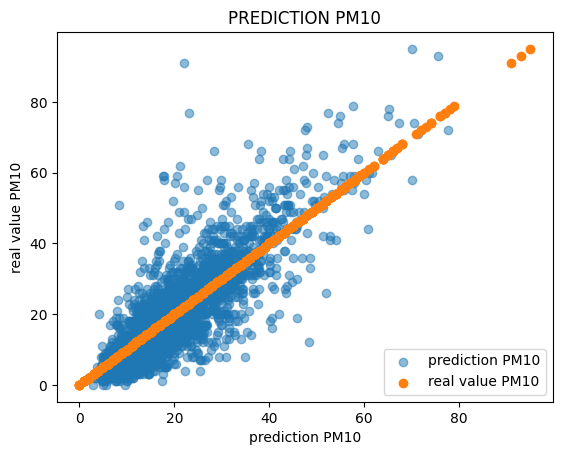

NItrogen dioxide


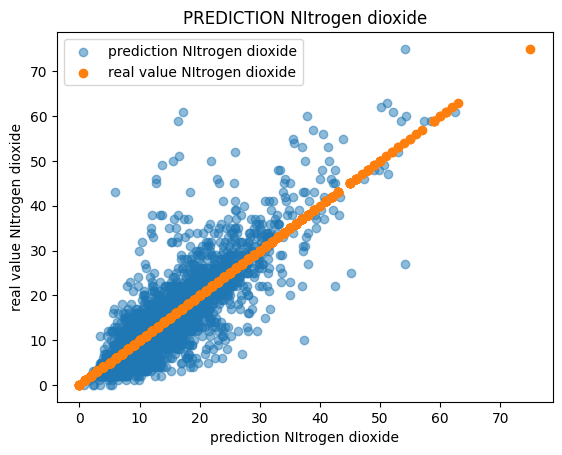

Sulfur dioxide


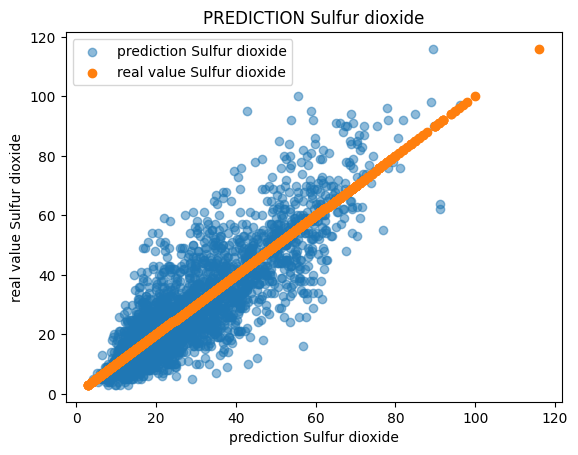

PM2.5


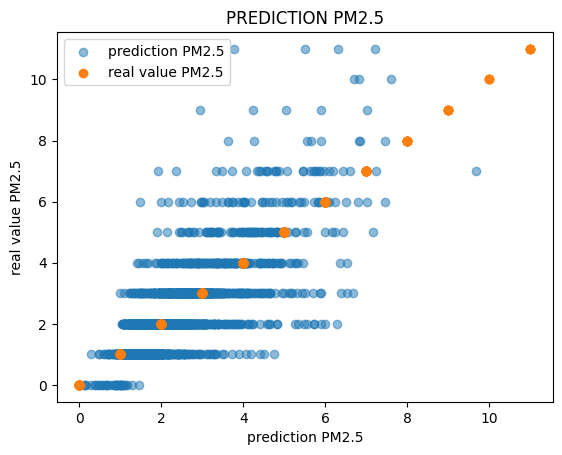

Ozone


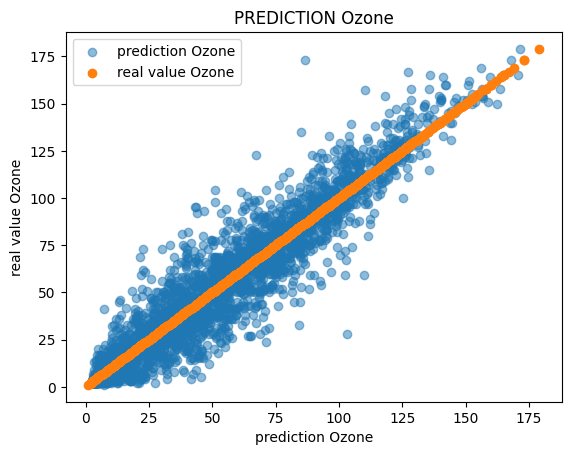

R-squared: 0.9619856658877628
MSE:  0.00393953142307667
RMSE:  0.001969765711538335
PM10


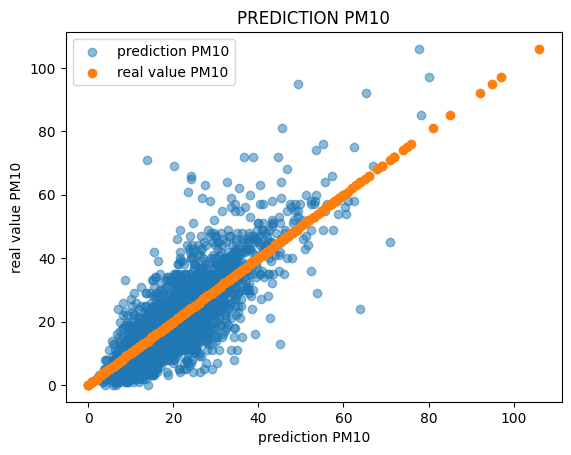

NItrogen dioxide


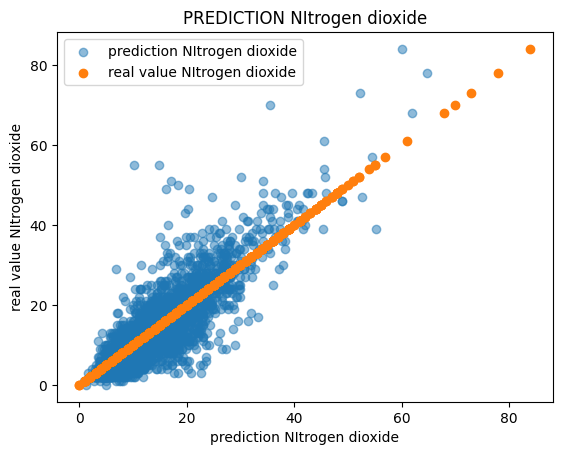

Sulfur dioxide


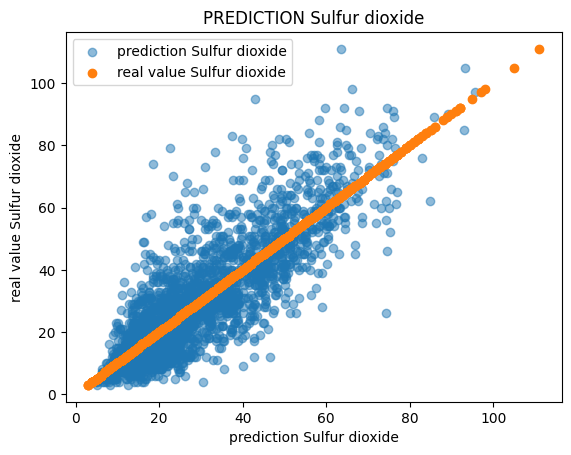

PM2.5


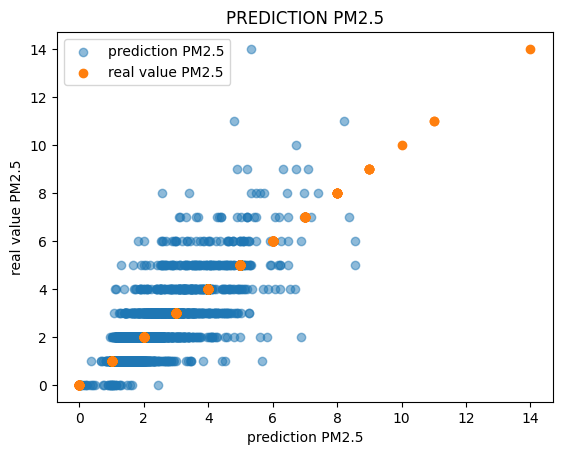

Ozone


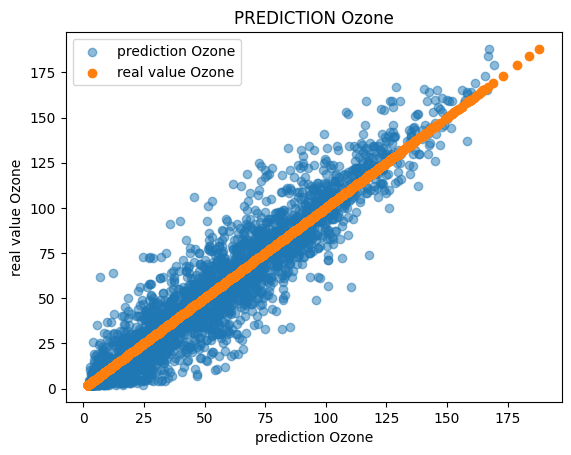

R-squared: 0.9618702693483897
MSE:  0.0037848015638323844
RMSE:  0.0018924007819161922
PM10


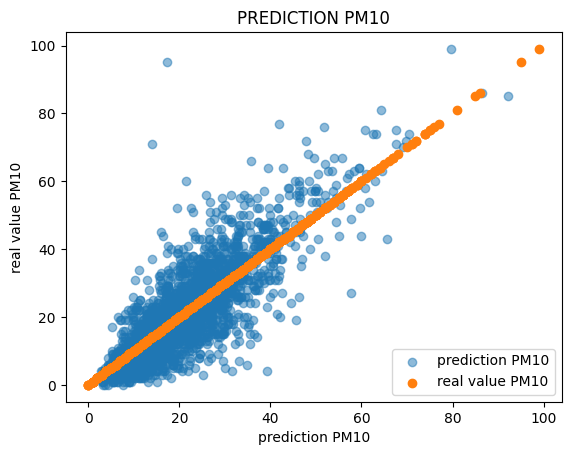

NItrogen dioxide


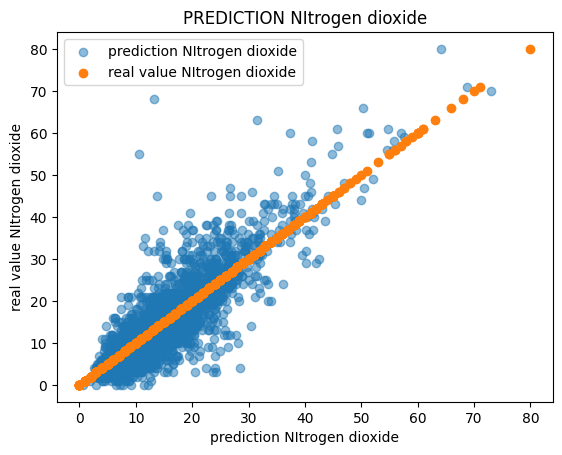

Sulfur dioxide


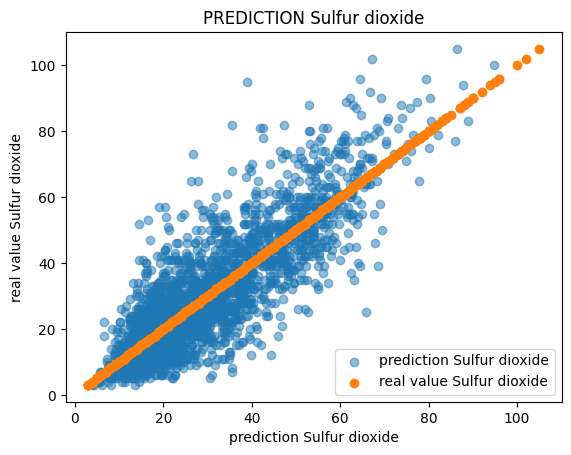

PM2.5


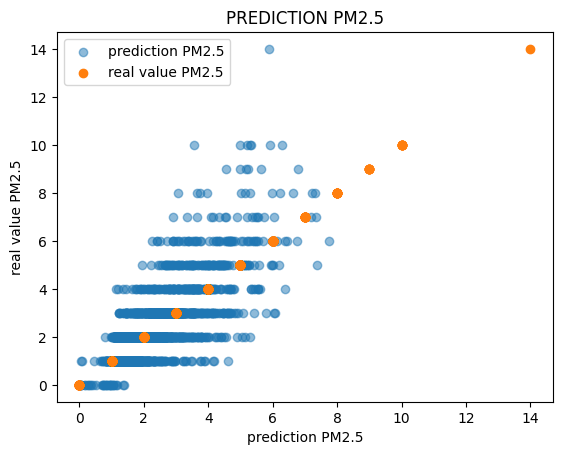

Ozone


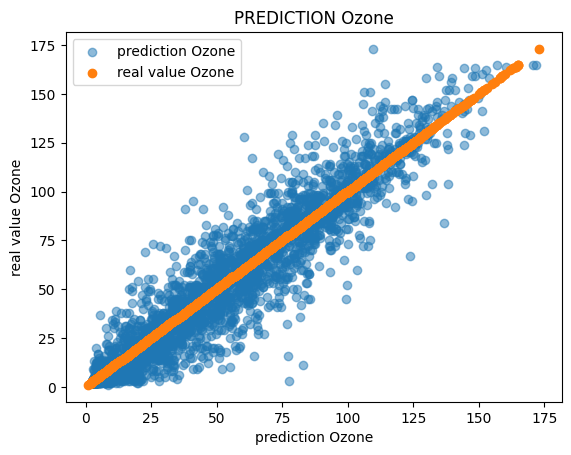

R-squared: 0.9624306194803491
MSE:  0.004032380194930138
RMSE:  0.002016190097465069
PM10


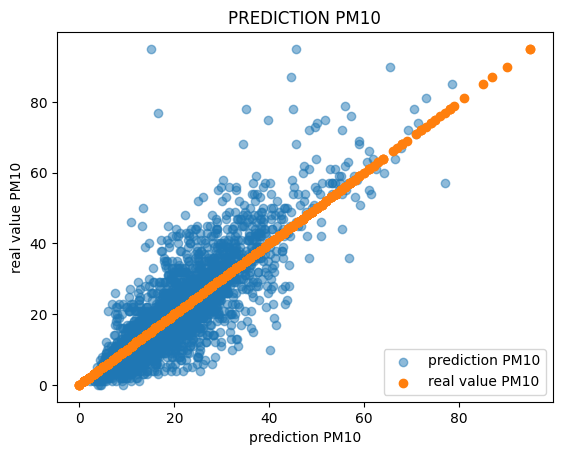

NItrogen dioxide


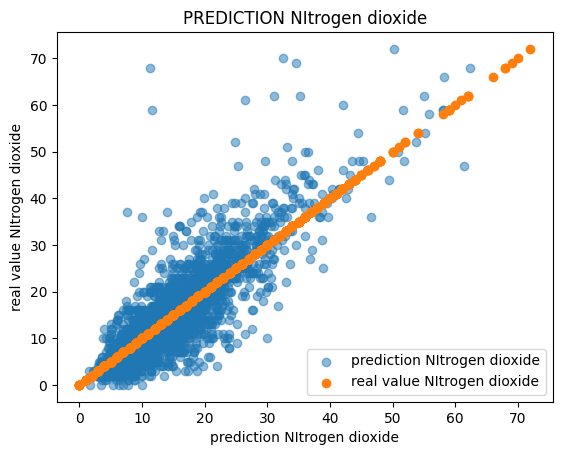

Sulfur dioxide


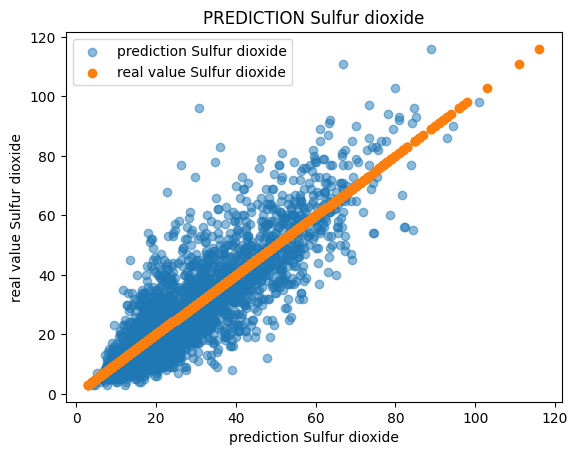

PM2.5


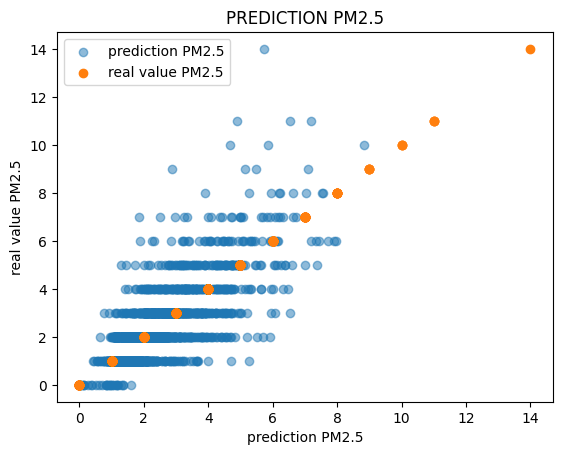

Ozone


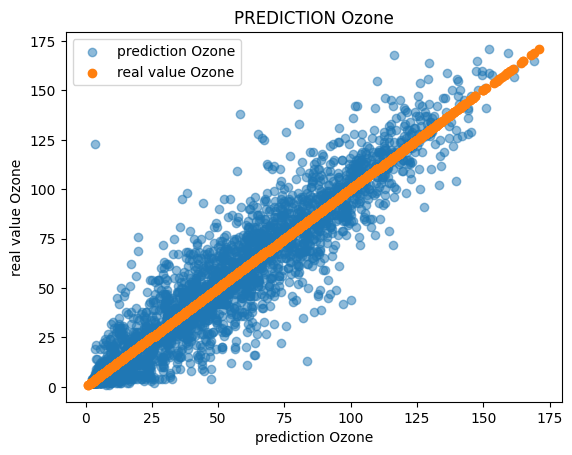

R-squared: 0.9629417551719787
MSE:  0.00410339161060696
RMSE:  0.00205169580530348
PM10


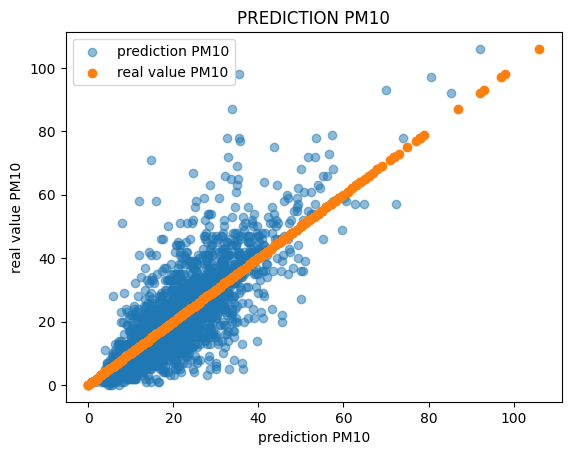

NItrogen dioxide


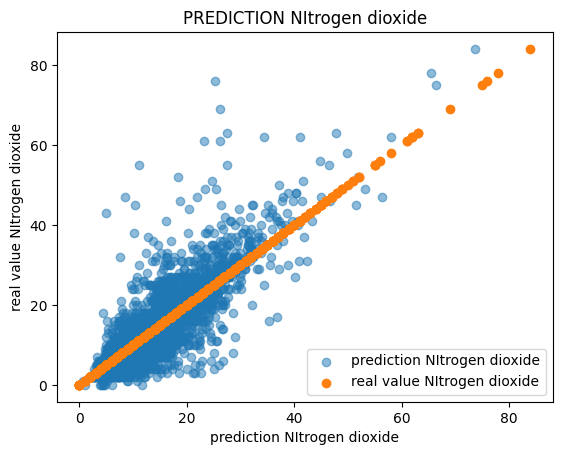

Sulfur dioxide


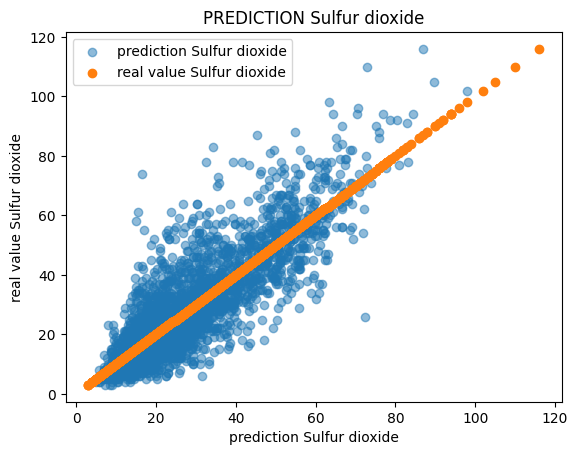

PM2.5


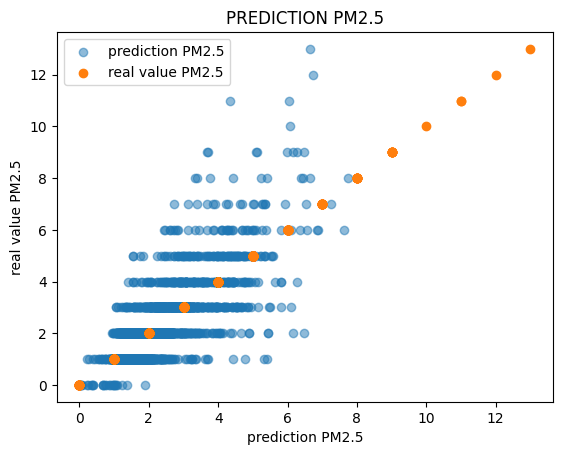

Ozone


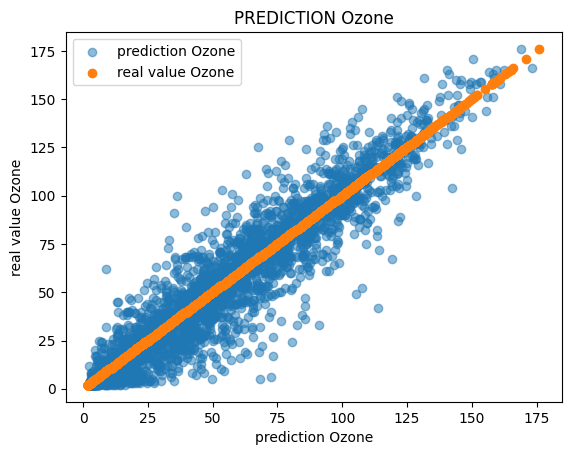

R-squared: 0.962323515829889
MSE:  0.004341836980857575
RMSE:  0.0021709184904287874
PM10


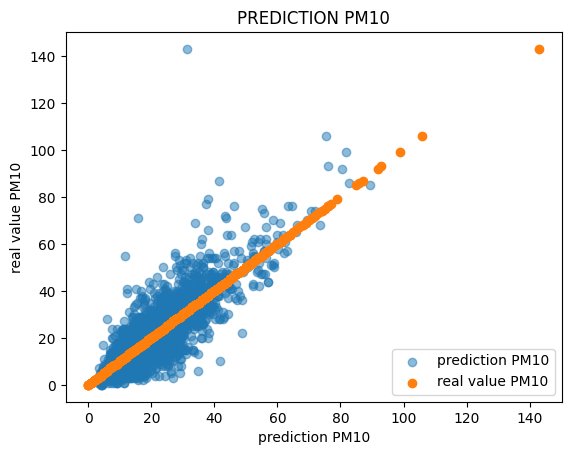

NItrogen dioxide


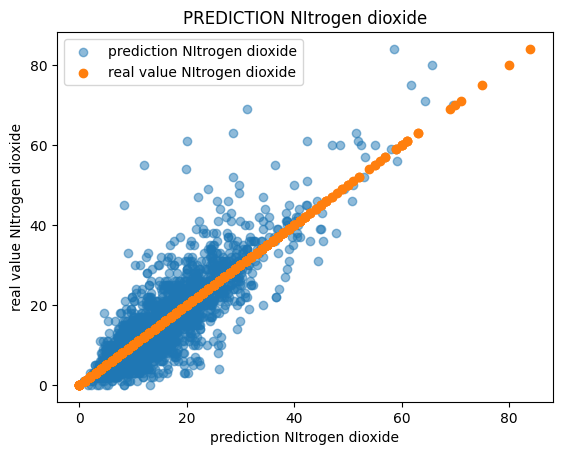

Sulfur dioxide


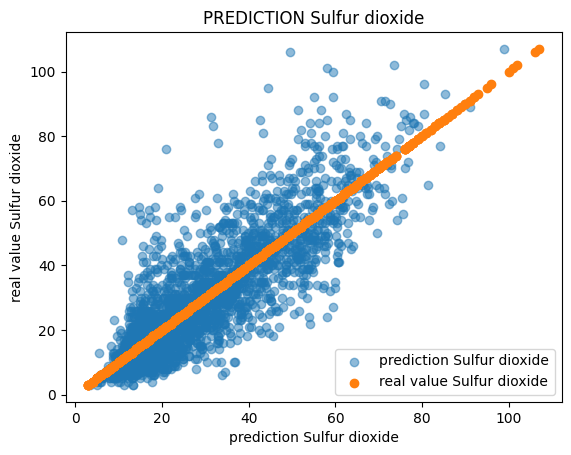

PM2.5


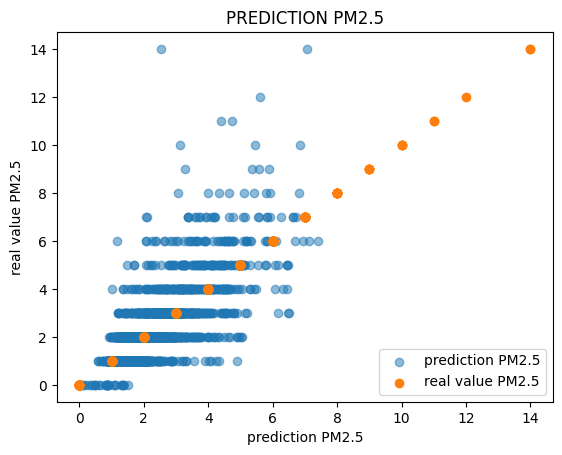

Ozone


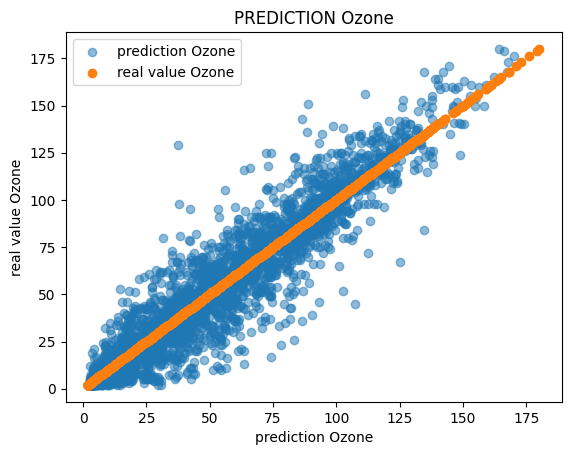

R-squared: 0.9627260031267009
MSE:  0.0038511367318215597
RMSE:  0.0019255683659107799
PM10


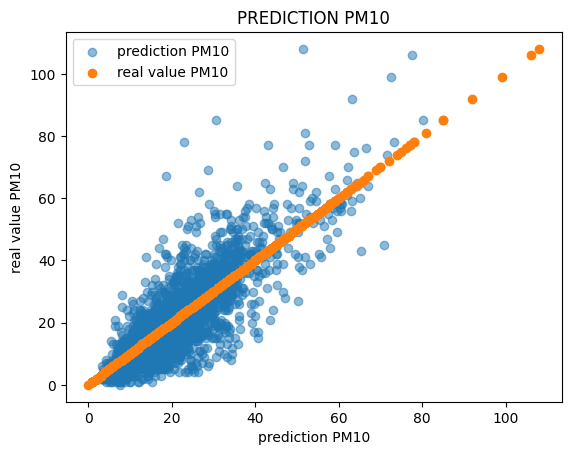

NItrogen dioxide


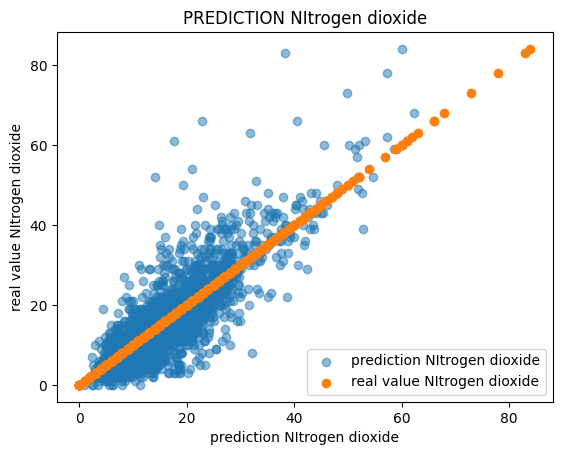

Sulfur dioxide


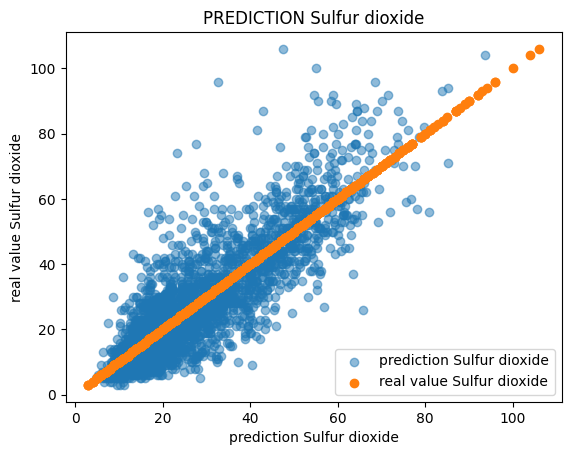

PM2.5


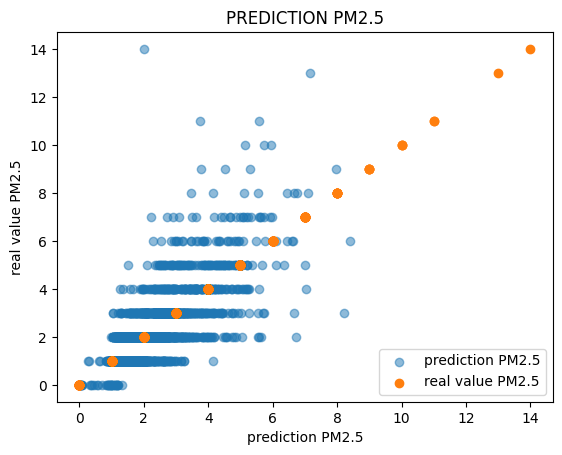

Ozone


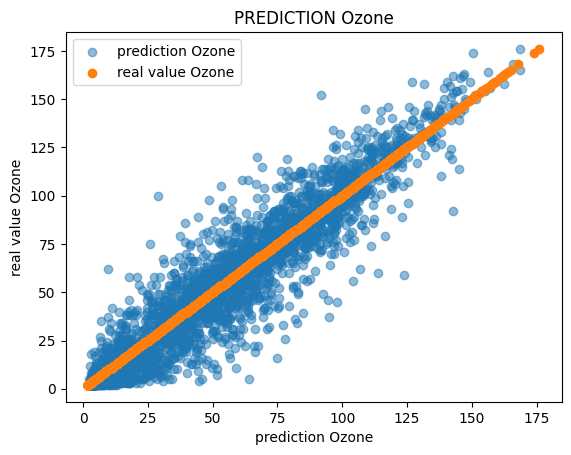

R-squared: 0.9631984312957499
MSE:  0.004512382240314704
RMSE:  0.002256191120157352
PM10


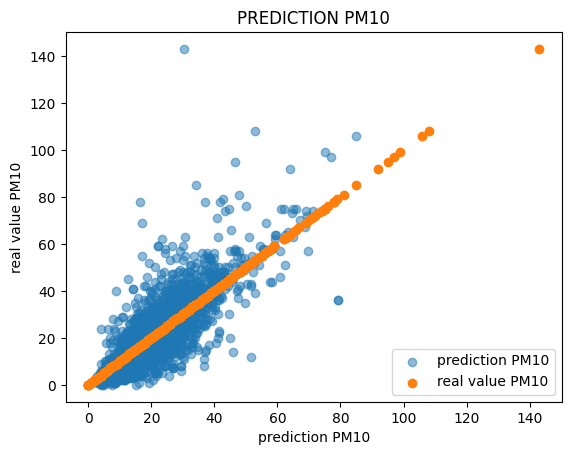

NItrogen dioxide


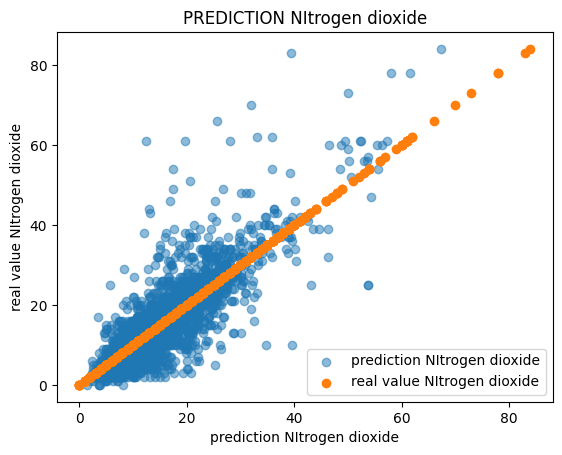

Sulfur dioxide


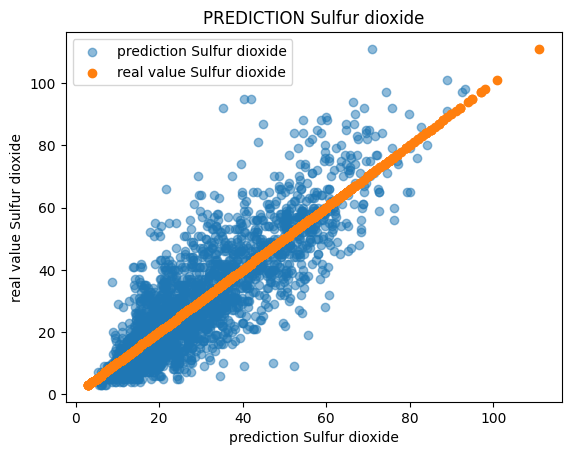

PM2.5


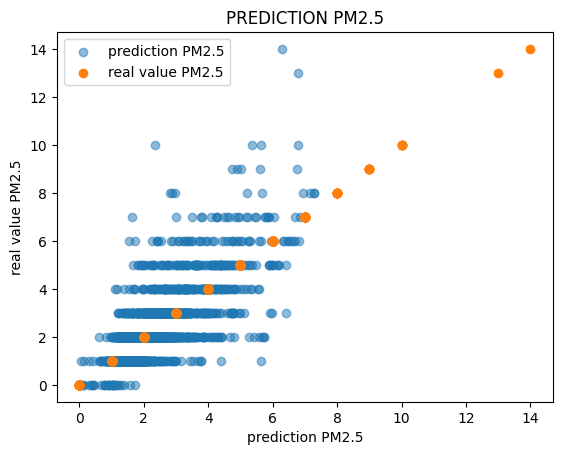

Ozone


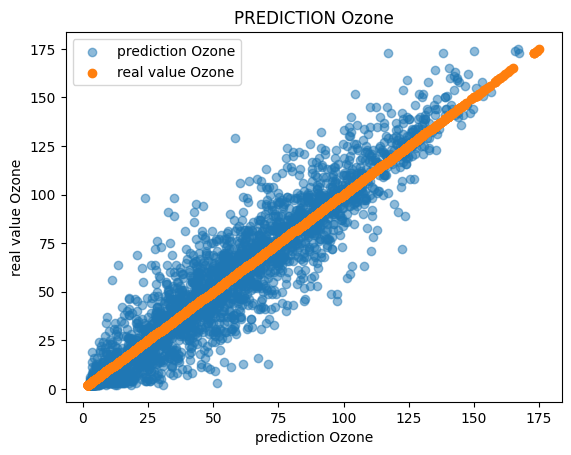

R-squared: 0.9620922883615057
MSE:  0.003865330763622699
RMSE:  0.0019326653818113495
PM10


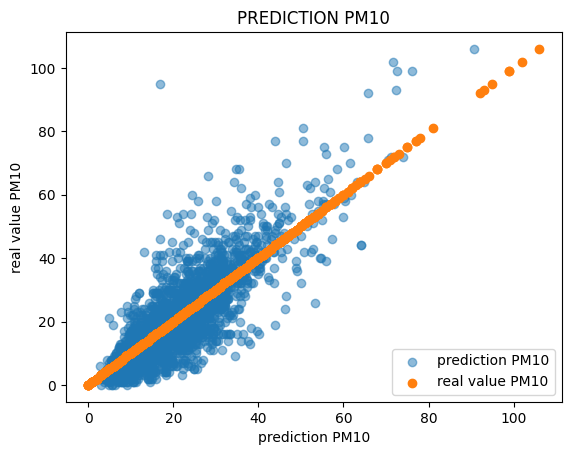

NItrogen dioxide


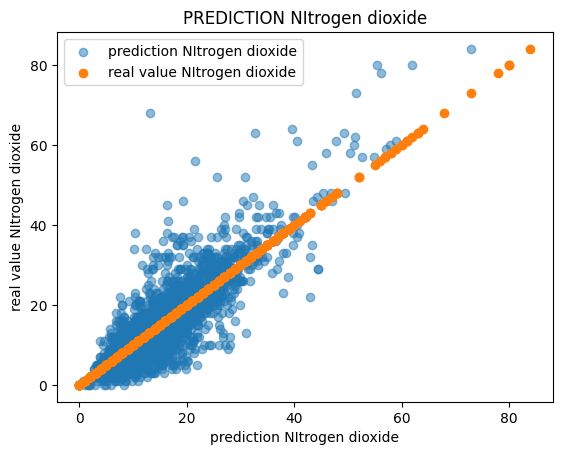

Sulfur dioxide


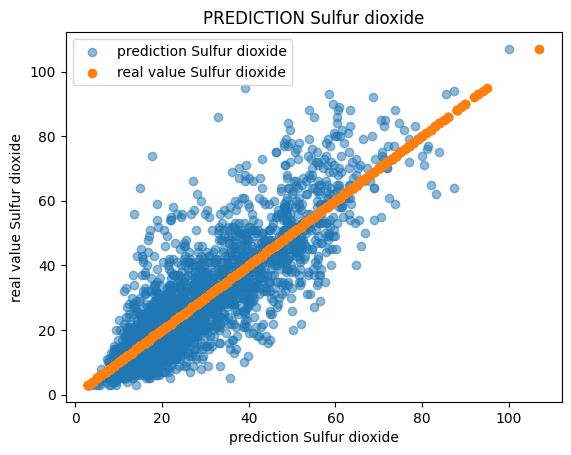

PM2.5


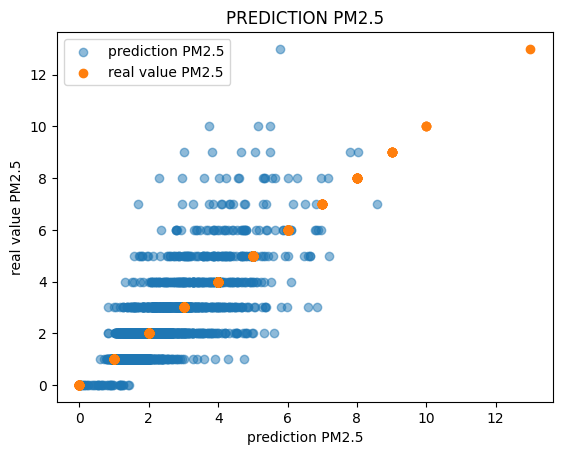

Ozone


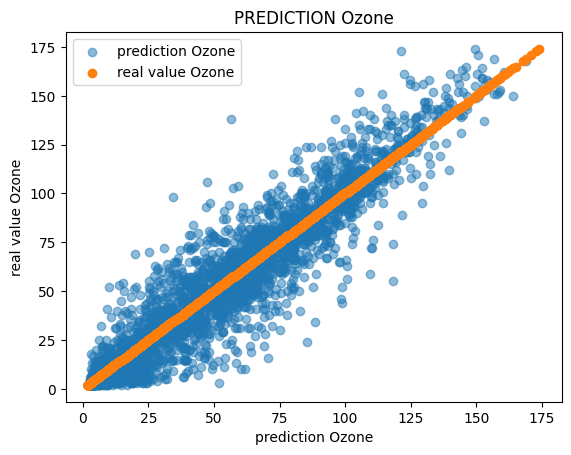

R-squared: 0.9624760098136207
MSE:  0.003928297661062884
RMSE:  0.001964148830531442
PM10


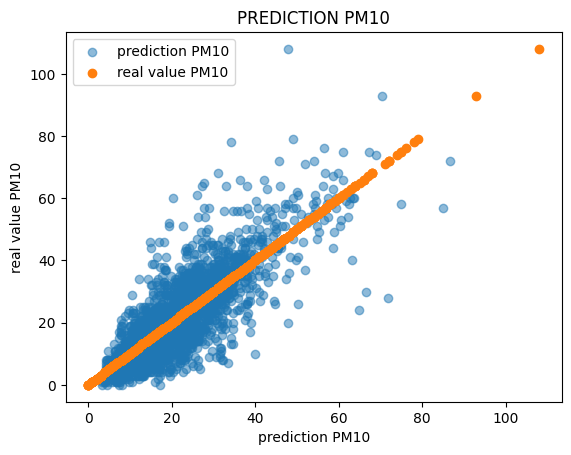

NItrogen dioxide


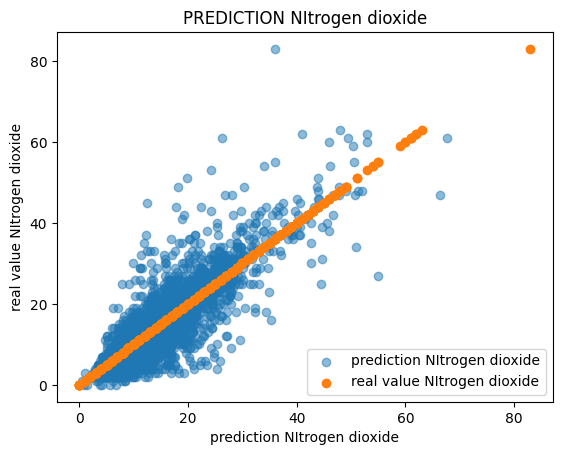

Sulfur dioxide


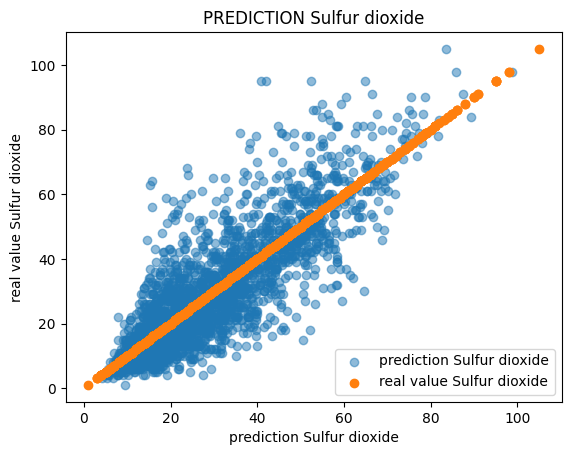

PM2.5


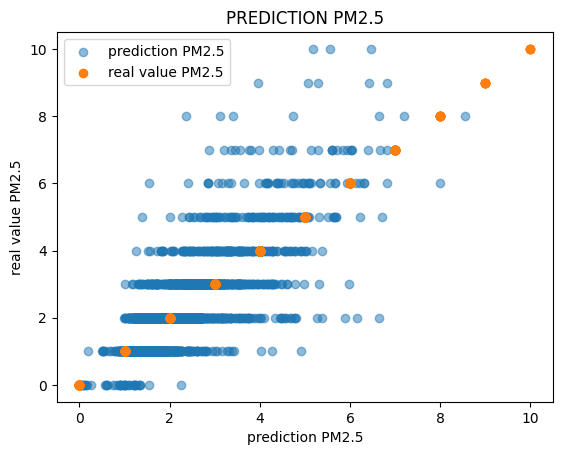

Ozone


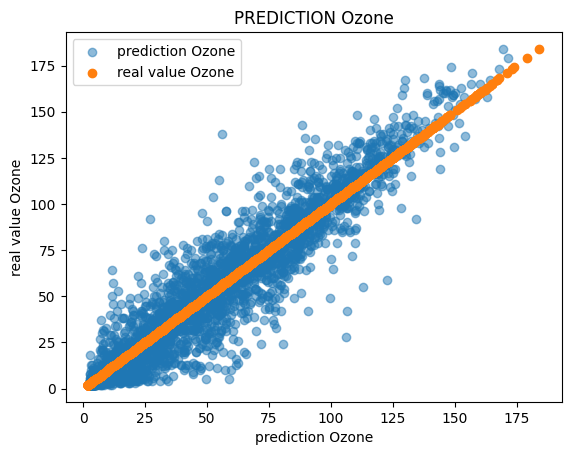

R-squared: 0.963632632304399
MSE:  0.004402015978803681
RMSE:  0.0022010079894018405
PM10


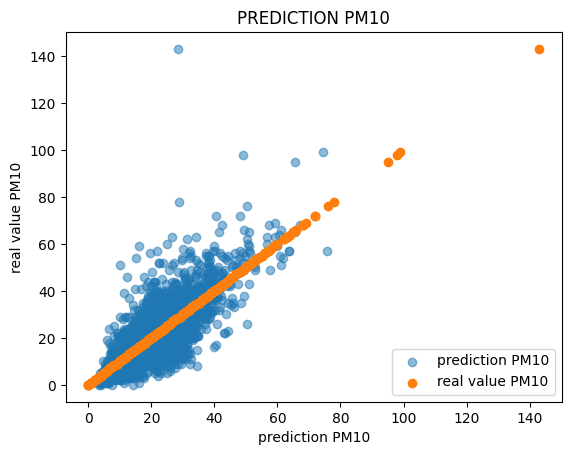

NItrogen dioxide


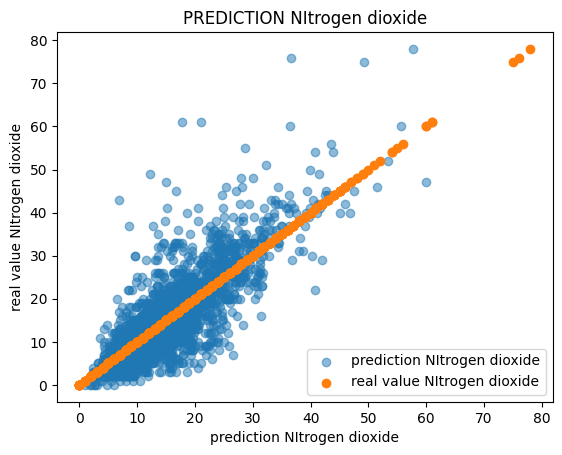

Sulfur dioxide


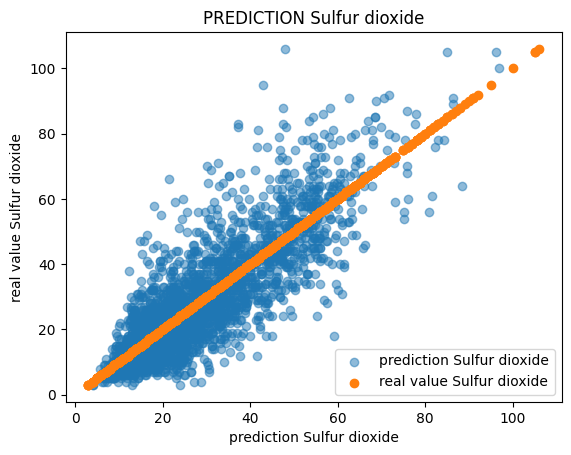

PM2.5


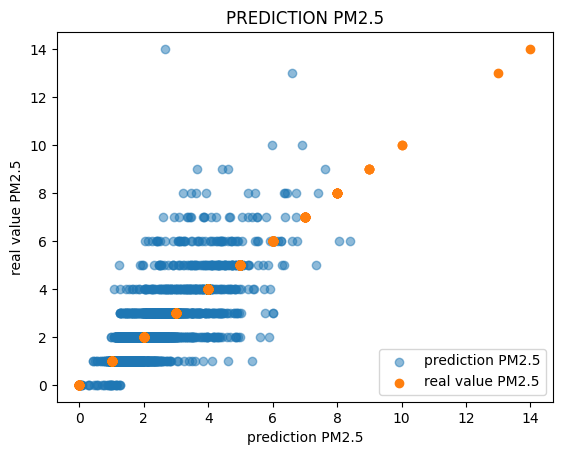

Ozone


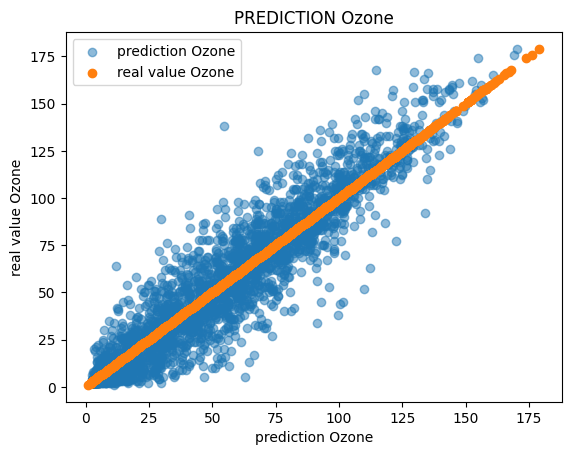

In [5]:
ind=0
lista_pollutant=[df1_StChiara, df4_StChiara, df5_StChiara, df7_StChiara, df8_StChiara, df9_StChiara, df11_StChiara, df12_StChiara, df13_StChiara, df14_StChiara, df15_StChiara] #df 9 and 10 are TBD

def tempo(df):
    timezone_offset = datetime.timedelta(hours=2)
    timezone = datetime.timezone(timezone_offset)
    df.ts = df.ts.apply(lambda x: x.replace(tzinfo=timezone))
    return df.ts
dfSC=dfSC.reset_index()
dfSC.ts=tempo(dfSC)
data_ini= ["2021-01-13", "2021-01-13", "2021-01-13", "2021-06-30", "2022-01-14", "2021-04-29", "2021-01-13", "2022-06-30", "2022-01-14", "2023-02-08", "2023-02-08"]
data_fini=["2023-02-08", "2023-06-26", "2021-04-29", "2023-06-26", "2023-06-26", "2022-01-14", "2023-06-26", "2023-02-08", "2023-06-26", "2023-06-26", "2023-06-26"]


change = {}
change["Biossido di Azoto"] = "Nitrogen dioxide"
change["Biossido Zolfo"] = "Sulfur dioxide"
change["Ozono"] = "Ozone"
dfAPPA = dfAPPA.rename(columns=change)

for i in lista_pollutant: 
    df_tot = dfAPPA.merge(lista_pollutant[ind].reset_index())

    df_tot = df_tot.set_index("ts")
    df_tot = df_tot.sort_index()
    df_tot = df_tot.dropna()
    df_tot = df_tot.reset_index()
    df_tot.ts=tempo(df_tot)

    DFTOT = df_tot.merge(dfSC[["ts","T", "RH", "P", "IAQ"]])

    try:
        DFTOT = DFTOT.set_index("ts")
    except:
        pass
    for i in DFTOT.columns:
        DFTOT[i] = pd.to_numeric(DFTOT[i],errors = "coerce" )
    DFTOT = DFTOT.dropna()

    DFTOT = DFTOT[data_ini[ind]:data_fini[ind]]

    X = DFTOT.drop(["PM10", "PM2.5", "Nitrogen dioxide", "Sulfur dioxide", "Ozone"], axis=1)

    y = DFTOT[["PM10", "PM2.5", "Nitrogen dioxide", "Sulfur dioxide", "Ozone"]].copy()

    try:
        INPUT_DIM = len(X.columns)
        OUTPUT_DIM = len(y.columns)
    except:
        INPUT_DIM = len(X.columns)
        OUTPUT_DIM=1

    x_train, x_test, y_train, y_test=train_test_split(X, y, shuffle = True, test_size=0.20)
    scaler=MinMaxScaler()
    scaler2 = MinMaxScaler()
    scaler.fit(x_train)

    X_train = scaler.transform(x_train)
    X_test = scaler.transform(x_test)


    scaler2.fit(y_train)

    y_train = scaler2.transform(y_train)
    y_test = scaler2.transform(y_test)

    rfr = RandomForestRegressor()
    RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                        max_depth=10, max_features=3, max_leaf_nodes=None,
                        max_samples=0.1, min_impurity_decrease=0.0,
                        min_samples_leaf=0.01,
                        min_samples_split=2, min_weight_fraction_leaf=0.0,
                        n_estimators=100, n_jobs=None, oob_score=False,
                        random_state=None, verbose=0, warm_start=False) 

    rfr.fit(x_train, y_train)
    score = rfr.score(x_train, y_train)

    print("R-squared:", score) 

    ypred = rfr.predict(x_test)

    mse = mean_squared_error(y_test, ypred)
    print("MSE: ", mse)
    print("RMSE: ", mse*(1/2.0)) 
    y_test = scaler2.inverse_transform(y_test)
    ypred = scaler2.inverse_transform(ypred)

    pollutant1 = "PM10"
    pollutant2 = "NItrogen dioxide"
    pollutant3 = "Sulfur dioxide"
    pollutant4 = "PM2.5"
    pollutant5 = "Ozone"

    pollutants = [pollutant1,pollutant2,pollutant3,pollutant4,pollutant5]

    for i,pollutant in enumerate(pollutants):
        plt.scatter(
            ypred[:,i],
            y_test[:,i]
            ,label="prediction " + pollutant,
            alpha=0.5
        )
        
        plt.scatter(
            y_test[:,i],
            y_test[:,i]
            ,label="real value " + pollutant
        )
        print(pollutant)

        plt.xlabel("prediction " + pollutant)
        plt.ylabel("real value " + pollutant)
        plt.title("PREDICTION " + pollutant)

        plt.legend()
        plt.show()
ind += 1


R-squared: 0.9601108450755694
MSE:  0.0032204692105925535
RMSE:  0.0016102346052962767
PM10


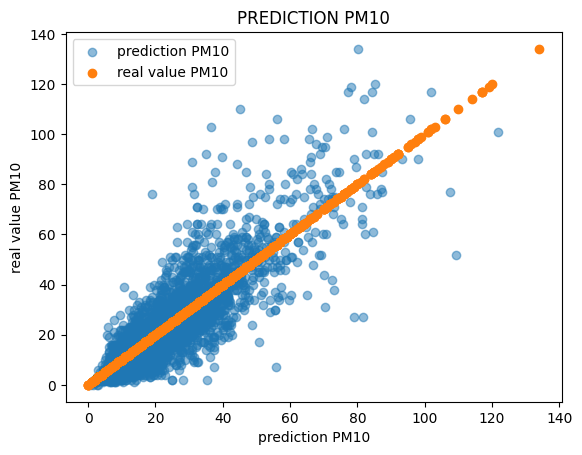

Nitrogen dioxide


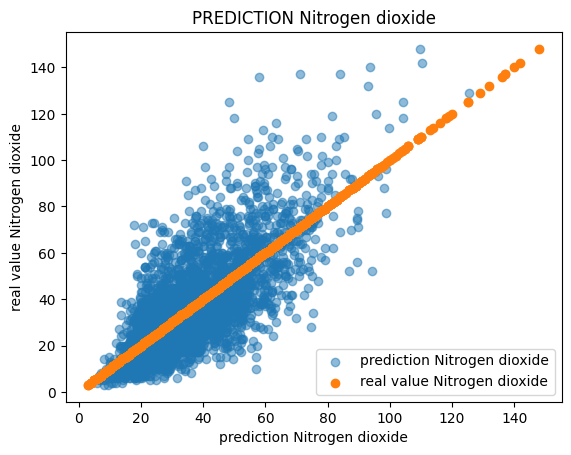

Carbon monoxide


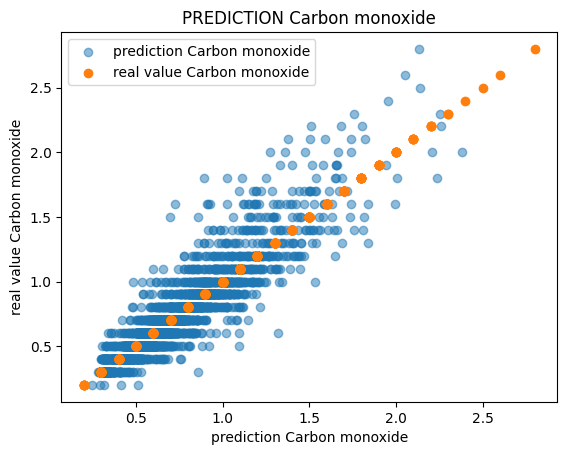

R-squared: 0.9496013752882329
MSE:  0.007308320042173538
RMSE:  0.003654160021086769
PM10


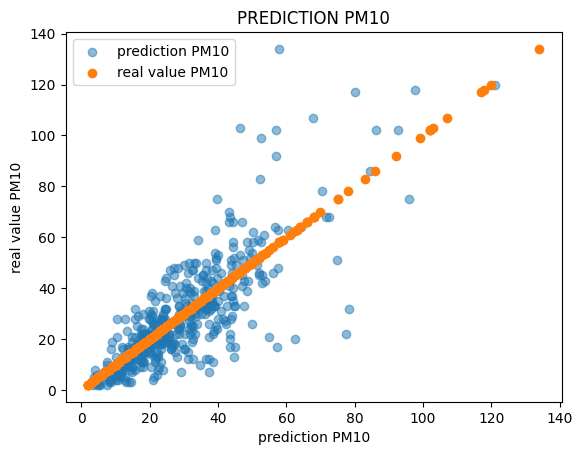

Nitrogen dioxide


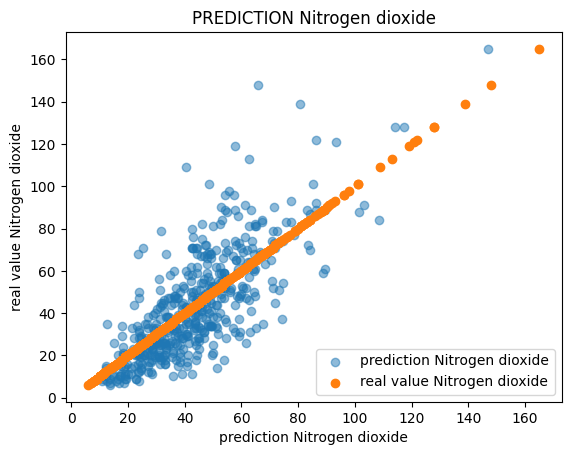

Carbon monoxide


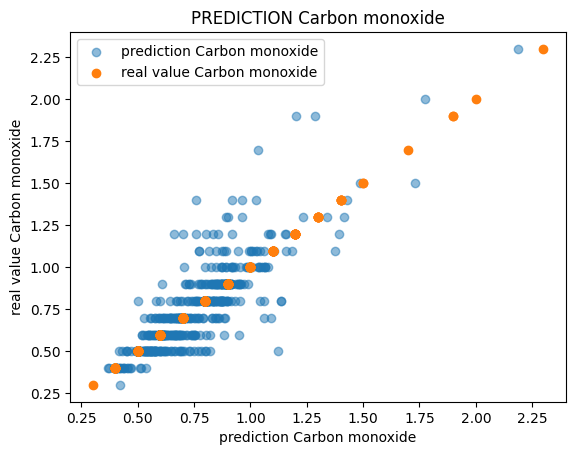

R-squared: 0.9598955271799481
MSE:  0.005072867873592798
RMSE:  0.002536433936796399
PM10


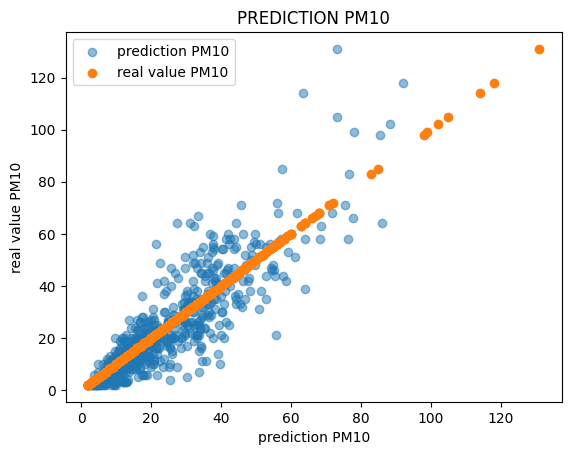

Nitrogen dioxide


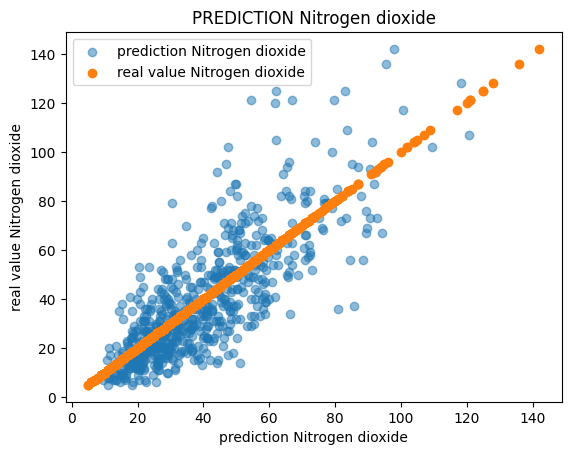

Carbon monoxide


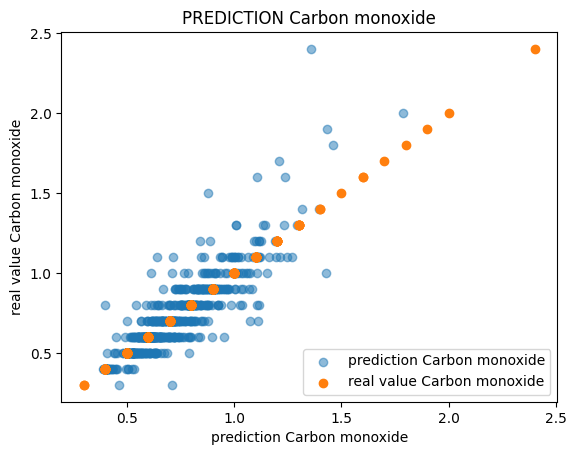

R-squared: 0.9679503798234541
MSE:  0.003786413002992081
RMSE:  0.0018932065014960406
PM10


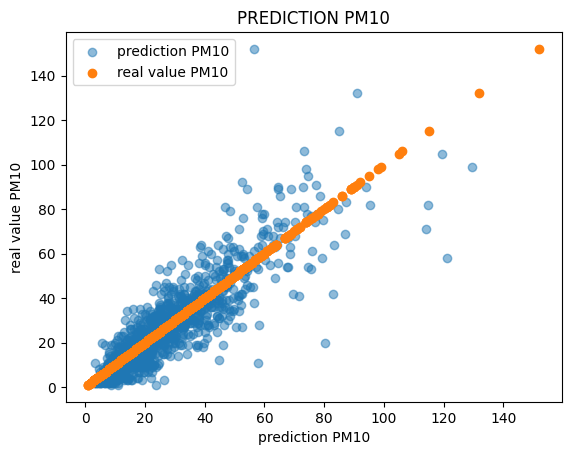

Nitrogen dioxide


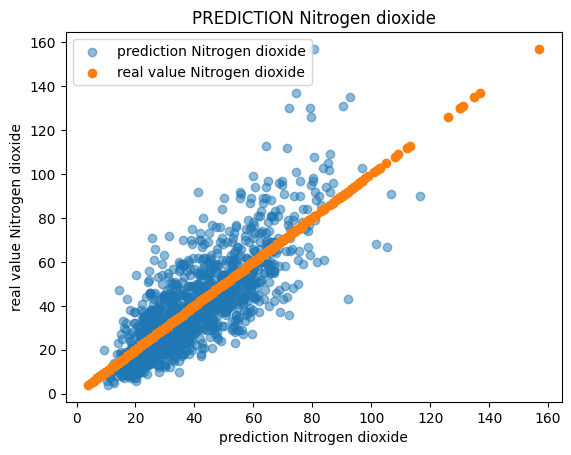

Carbon monoxide


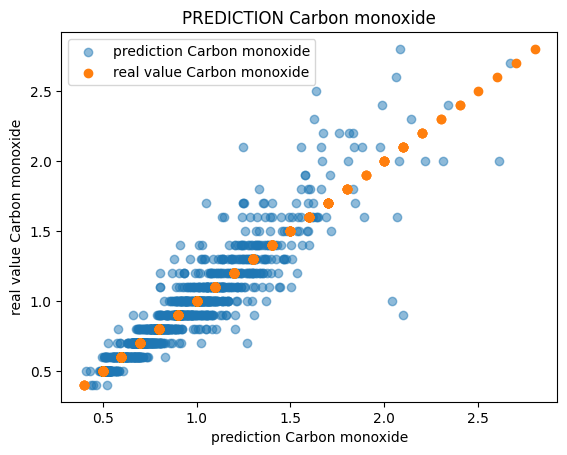

R-squared: 0.9543376232028297
MSE:  0.007269879555678396
RMSE:  0.003634939777839198
PM10


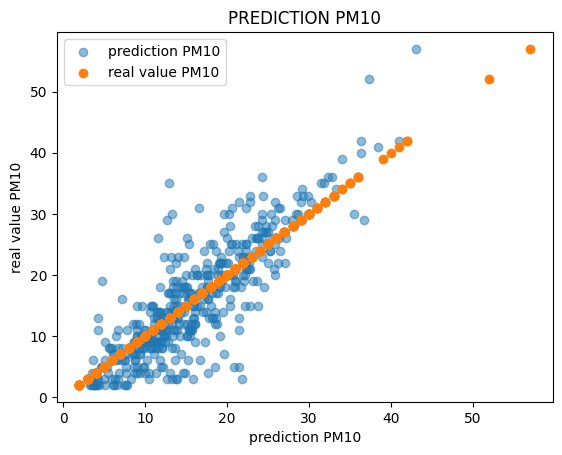

Nitrogen dioxide


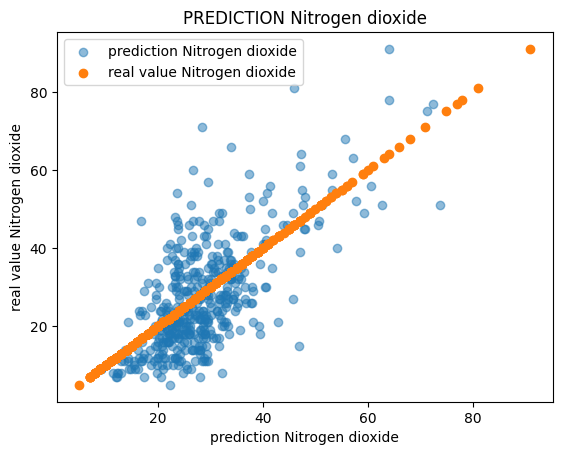

Carbon monoxide


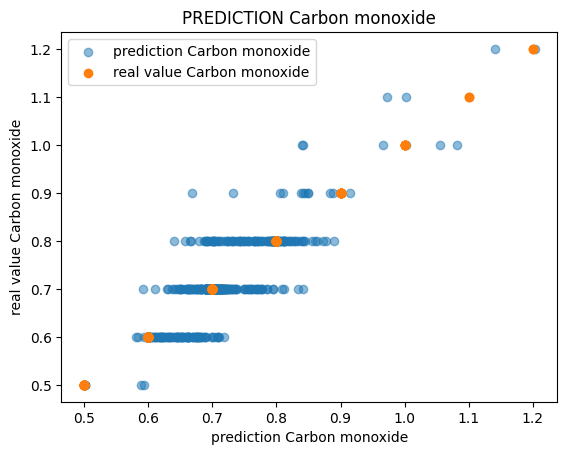

R-squared: 0.964452795297618
MSE:  0.0030790854967747074
RMSE:  0.0015395427483873537
PM10


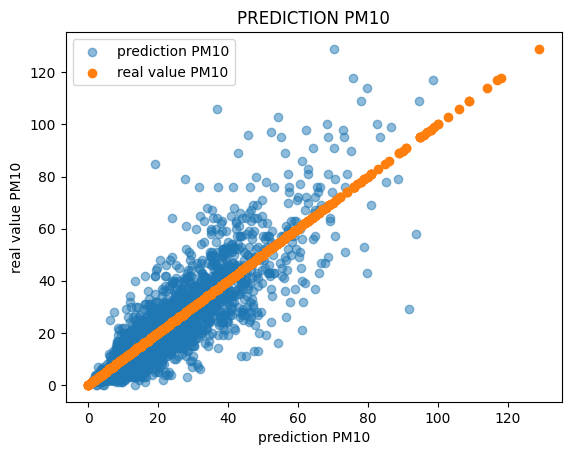

Nitrogen dioxide


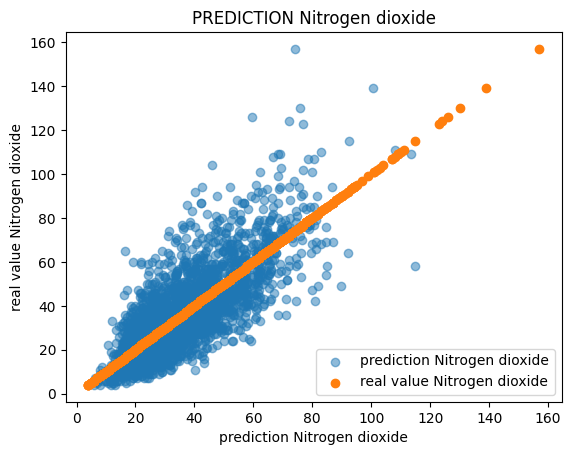

Carbon monoxide


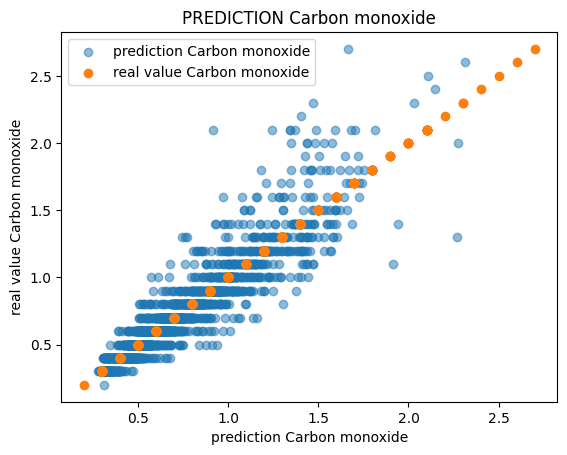

R-squared: 0.9476647383936192
MSE:  0.004425046409642135
RMSE:  0.0022125232048210673
PM10


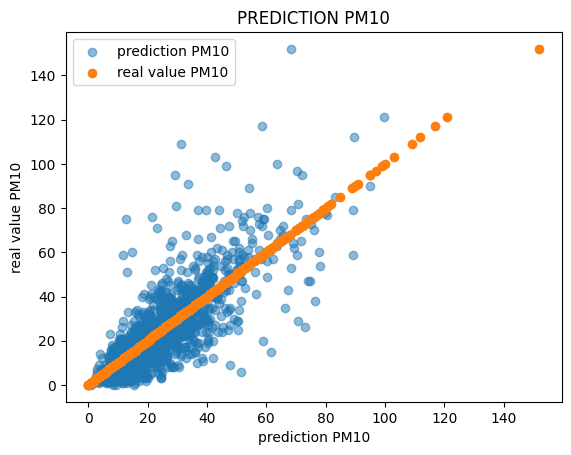

Nitrogen dioxide


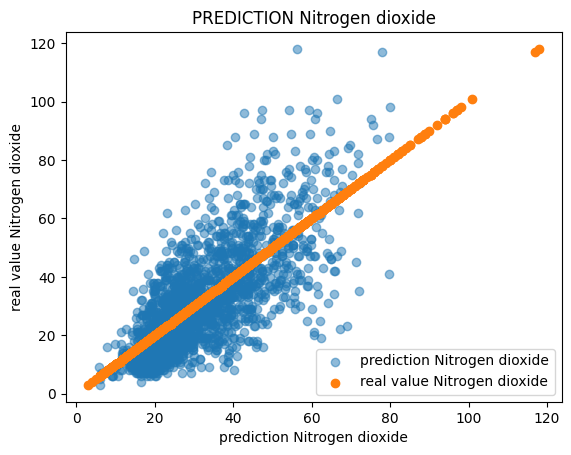

Carbon monoxide


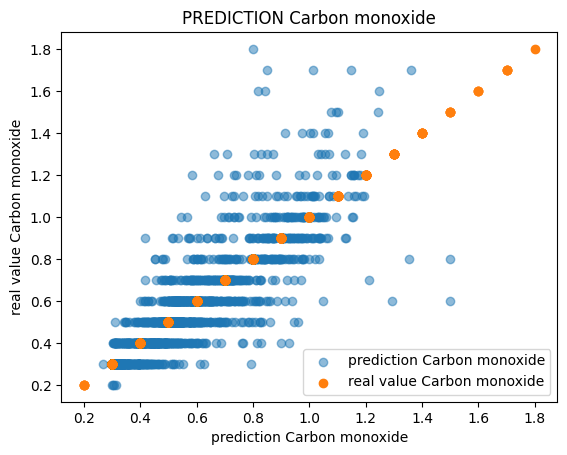

R-squared: 0.963663259447566
MSE:  0.003338079684857897
RMSE:  0.0016690398424289484
PM10


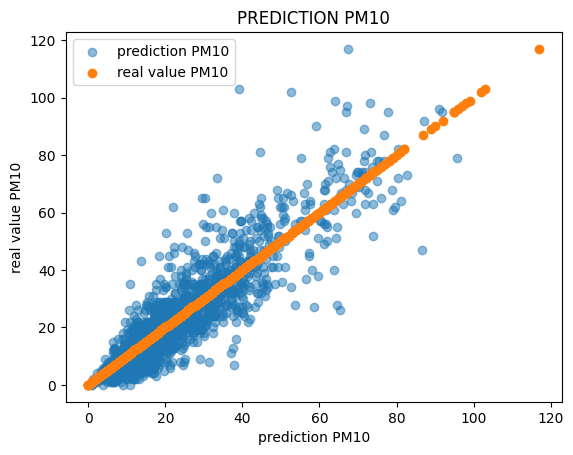

Nitrogen dioxide


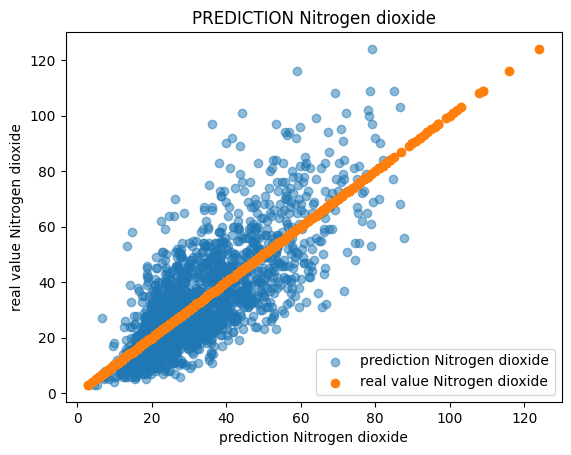

Carbon monoxide


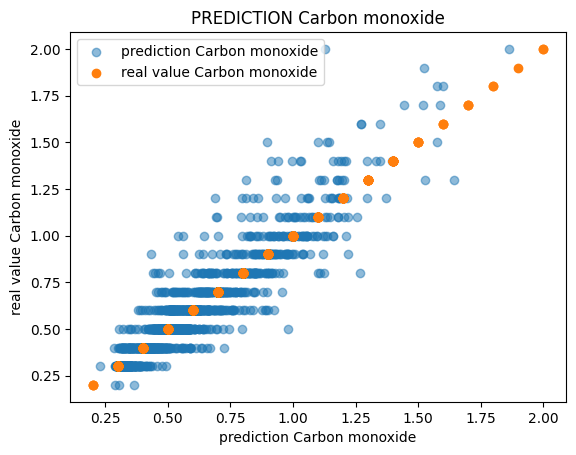

In [6]:
ind=0
lista_pollutant1=[df1, df4, df5, df8, df10, df11, df12, df14]

def tempo(df):
    timezone_offset = datetime.timedelta(hours=2)
    timezone = datetime.timezone(timezone_offset)
    df.ts = df.ts.apply(lambda x: x.replace(tzinfo=timezone))
    return df.ts
df_ViaBolz=df_ViaBolz.reset_index()
df_ViaBolz.ts=tempo(df_ViaBolz)
data_ini1= ["2021-01-13", "2021-01-13", "2021-01-13", "2021-06-30", "2021-04-29", "2021-06-30", "2022-02-24", "2022-02-24"]
data_fini1=["2023-06-26", "2021-04-29", "2021-06-30", "2023-05-24", "2022-02-24", "2023-06-26", "2023-06-26", "2023-06-26"]

change = {}
change["Biossido di Azoto"] = "Nitrogen dioxide"
change["Ossido di Carbonio"] = "Carbon monoxide"
dfAPPA = dfAPPA.rename(columns=change)

for i in lista_pollutant1: 
    df_tot1 = dfAPPA2.merge(lista_pollutant1[ind].reset_index())

    df_tot1 = df_tot1.set_index("ts")
    df_tot1 = df_tot1.sort_index()
    df_tot1 = df_tot1.dropna()
    df_tot1 = df_tot1.reset_index()
    df_tot1.ts=tempo(df_tot1)

    DFTOT1 = df_tot1.merge(df_ViaBolz[["ts","T", "RH", "P"]])

    try:
        DFTOT1 = DFTOT1.set_index("ts")
    except:
        pass
    
    for i in DFTOT1.columns:
        DFTOT1[i] = pd.to_numeric(DFTOT1[i],errors = "coerce" )
    DFTOT1 = DFTOT1.dropna()

    DFTOT1 = DFTOT1[data_ini1[ind]:data_fini1[ind]]


    X = DFTOT1.drop(["PM10", "Biossido di Azoto", "Ossido di Carbonio"], axis=1)

    y = DFTOT1[["PM10", "Biossido di Azoto", "Ossido di Carbonio"]].copy()

    try:
        INPUT_DIM = len(X.columns)
        OUTPUT_DIM = len(y.columns)
    except:
        INPUT_DIM = len(X.columns)
        OUTPUT_DIM=1

    x_train, x_test, y_train, y_test=train_test_split(X, y, shuffle = True, test_size=0.20)
    scaler=MinMaxScaler()
    scaler2 = MinMaxScaler()
    scaler.fit(x_train)

    X_train = scaler.transform(x_train)
    X_test = scaler.transform(x_test)

    scaler2.fit(y_train)

    y_train = scaler2.transform(y_train)
    y_test = scaler2.transform(y_test)

    rfr = RandomForestRegressor()
    RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                        max_depth=10, max_features=3, max_leaf_nodes=None,
                        max_samples=0.1, min_impurity_decrease=0.0,
                        min_samples_leaf=0.01,
                        min_samples_split=2, min_weight_fraction_leaf=0.0,
                        n_estimators=100, n_jobs=None, oob_score=False,
                        random_state=None, verbose=0, warm_start=False) 

    rfr.fit(x_train, y_train)
    score = rfr.score(x_train, y_train)

    print("R-squared:", score) 

    ypred = rfr.predict(x_test)

    mse = mean_squared_error(y_test, ypred)
    print("MSE: ", mse)
    print("RMSE: ", mse*(1/2.0)) 
    y_test = scaler2.inverse_transform(y_test)
    ypred = scaler2.inverse_transform(ypred)


    pollutant1 = "PM10"
    pollutant2 = "Nitrogen dioxide"
    pollutant3 = "Carbon monoxide"

    pollutants = [pollutant1,pollutant2,pollutant3]

    for i,pollutant in enumerate(pollutants):
        plt.scatter(
            ypred[:,i],
            y_test[:,i]
            ,label="prediction " + pollutant,
            alpha=0.5
        )
        
        plt.scatter(
            y_test[:,i],
            y_test[:,i]
            ,label="real value " + pollutant
        )
        print(pollutant)

        plt.xlabel("prediction " + pollutant)
        plt.ylabel("real value " + pollutant)
        plt.title("PREDICTION " + pollutant)

        plt.legend()
        plt.show()
    ind += 1
